### IF YOU WANT TO SEE HOW I PERFORMED FEATURE ENGINEERING, SEE BELOW.

https://github.com/cl20813/DS-projects/blob/main/trav/data_engineering_lightgbm.ipynb



In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

The goal of the project is to predict policy holders who are likely to change from prospect to policy holder by choosing Travelers. This is a classification problem with binary response variable "convert_ind", where 0 indicates the policy holder continues to use Travelers. 

In [5]:
df = pd.read_csv("C:\\Users\\joonw\\trav\\trav_dataset3.csv")

# Convert object columns to categorical.
# Note that there is no categorical format in previous data,
# so some variables are changed to object type.
categorical_columns = ['credit_score_bin', 'Prior_carrier_grp']
for col in categorical_columns:
    df[col] = df[col].astype('category')

#### Spliting dataset into training set and testing set

Since the data is imbalanced, I splited the train and test set using 'stratify=df['convert_ind']' option.

In [6]:
# test_set = df.sample(frac=0.2, random_state=24)
# test_mask = df.index.isin(test_set.index)
# train_set = df.loc[~test_mask,:].reset_index(drop=True)
# test_set = test_set.reset_index(drop=True)

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, stratify=df['convert_ind'], random_state=24)

# Separate features and target from the entire training set
train_y = train_set['convert_ind']
train_x = train_set.drop(columns=['convert_ind'])

test_y = test_set['convert_ind']
test_x = test_set.drop(columns=['convert_ind'])

#### Modeling After Optimizing Hyperparameters

In [7]:
# Define the best hyperparameters from cross-validation
best_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': ['auc', 'average_precision'],
    'num_leaves': 15,  # optimal   15>14,20,16, 18
    'learning_rate': 0.009, # 0.009>0.01, 0.008,0.007 >0.005,0.02> 0.003, 0.004, 0.006
    'feature_fraction': 0.8, # 0.8 >0.75 for prob but not for label
    # 0.6> 0.55, 0.65> 0.7 >0.75 
    'bagging_fraction': 0.8,  #0.8>0.6 ,0.7 , 0.85
    'bagging_freq': 5, # 5>4,6
    'random_state': 42,
    'min_data_in_leaf': 20, # 20> 15,18, 22
    'lambda_l1': 1,  # this 1,0.1 is nearly optimal
    'lambda_l2': 0.1,
    'n_jobs': -1,  # Use all CPU cores
    'max_depth': 12,  # Prevent overfitting 6 default  5>6,4   
    # but 4 is better for prob and 5 is better for label prediction
    'min_gain_to_split': 0,  # Minimum gain for splitting
    # 0.005 >0 for label but 0 better for probability prediction
    'max_bin': 255,  # Precision for bins
    'min_sum_hessian_in_leaf': 1e-2,  # Prevent overfitting in leaves 1e-3=1e-2
    
}

# Create the full LightGBM dataset
full_train_dataset = lgb.Dataset(train_x, label=train_y)

# Define a logging callback
callbacks = [lgb.log_evaluation(period=50)]

# Train the model on the full training set
final_model = lgb.train(
    best_params,
    full_train_dataset,
    num_boost_round=2000,  # Use a high value to allow full convergence
    valid_sets=[full_train_dataset],  # round 2000 to 5000 not helpful
    valid_names=['train'],
    callbacks=callbacks  # Use callbacks for logging
)

# Save the model for future use
final_model.save_model('final_model.txt')

[LightGBM] [Info] Number of positive: 11310, number of negative: 90227
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1361
[LightGBM] [Info] Number of data points in the train set: 101537, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111388 -> initscore=-2.076641
[LightGBM] [Info] Start training from score -2.076641
[50]	train's auc: 0.698075	train's average_precision: 0.250666
[100]	train's auc: 0.71121	train's average_precision: 0.260933
[150]	train's auc: 0.717294	train's average_precision: 0.267067
[200]	train's auc: 0.723331	train's average_precision: 0.273127
[250]	train's auc: 0.728767	train's average_precision: 0.27877
[300]	train's auc: 0.734172	train's average_precision: 0.285106
[350]	train's auc: 0.738986	train's average_precision: 0.290

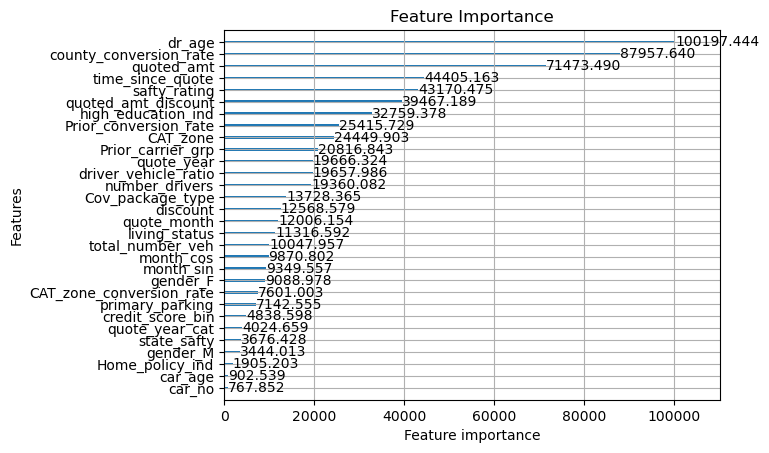

In [8]:
lgb.plot_importance(final_model, max_num_features=30, importance_type='gain')
plt.title("Feature Importance")
plt.show()

# Results

AUC score is a cumulative measure of a classifier's ability to detect true positives as the Type I error rate (i.e., False Positive Rate) varies.

If your goal is to predict the probability of conversion, then AUC is a good metric. However, if you want to evaluate performance after predicting labels, you should consider metrics like recall, precision, and F1-score, as AUC does not depend on the classification threshold, but these metrics do.

But I added AUC score for class prediction as well because I don't want a model that shows a huge discrepancy between two scores. 

In [9]:
test_y = test_set['convert_ind']
test_x = test_set.drop(columns=['convert_ind'])

mm = df['convert_ind'].mean()

test_pred = final_model.predict(test_x)
test_pred2 = (test_pred > mm).astype(int)
test_auc = roc_auc_score(test_y, test_pred)
test_auc2 = roc_auc_score(test_y, test_pred2)
print(f"Test data, probability prediction AUC: {test_auc:.4f}")
print(f"Test data, class {0,1} prediction AUC: {test_auc2:.4f}")

Test data, probability prediction AUC: 0.8015
Test data, class (0, 1) prediction AUC: 0.7215


### Is this a good model for imbalanced data?

While the project required to predict the probability of conversion, so looking at the AUC is enough and 0.8015 is quite good but for the real business problems, we need to look at other scores as well.

In [11]:
cm = confusion_matrix(test_y, test_pred2)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[15250  7307]
 [  659  2169]]

True Positives(TP) =  15250

True Negatives(TN) =  2169

False Positives(FP) =  7307

False Negatives(FN) =  659


In [12]:
print(classification_report(test_y, test_pred2))

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.79     22557
         1.0       0.23      0.77      0.35      2828

    accuracy                           0.69     25385
   macro avg       0.59      0.72      0.57     25385
weighted avg       0.88      0.69      0.74     25385



It is important to see the scores for Class 1.0. There is a room for improvement if precision and f1-score are important. However, considering the business, I think it is important to aim for high recall in class 1, and the score 0.77 is quite good for the business. 

#### Reference: Hyper Parameter Optimization

It seems grid search is more efficient than RandomizedSearch

In [ ]:
def evaluate_model(params, train_x, train_y, skf):
    """Evaluate a model with the given parameters using cross-validation."""
    train_set = lgb.Dataset(train_x, label=train_y)
    
    # Perform cross-validation
    cv_results = lgb.cv(
        params,
        train_set,
        num_boost_round=2000,
        folds=skf.split(train_x, train_y),
        metrics='auc',
        seed=42
    )
    
    # Get the best AUC score
    score = max(cv_results['valid auc-mean'])
    return score

# Parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': np.arange(10, 20),
    'learning_rate': [0.005, 0.01, 0.02, 0.03],
    'feature_fraction': [0.75, 0.8, 0.85],
    'min_data_in_leaf': [10, 20, 30],
    'lambda_l1': 1,
    'lambda_l2': 0.1,
    'early_stopping_rounds':50
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
best_score = 0
best_params = None

# Create a list of all parameter combinations
param_combinations = [
    {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'feature_fraction': feature_fraction,
        'min_data_in_leaf': min_data_in_leaf,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'random_state': 42,
        'is_unbalance': True
    }
    for num_leaves in param_grid['num_leaves']
    for learning_rate in param_grid['learning_rate']
    for feature_fraction in param_grid['feature_fraction']
    for min_data_in_leaf in param_grid['min_data_in_leaf']
    for lambda_l1 in param_grid['lambda_l1']
    for lambda_l2 in param_grid['lambda_l2']
]

# Evaluate parameter combinations in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
    futures = [
        executor.submit(evaluate_model, params, train_x, train_y, skf)
        for params in param_combinations
    ]
    for future, params in zip(concurrent.futures.as_completed(futures), param_combinations):
        score = future.result()
        print(f"Params: {params}, AUC: {score}")
        if score > best_score:
            best_score = score
            best_params = params